<a href="https://colab.research.google.com/github/Salvoaf/BreastCancerClassification/blob/main/Pre-trained_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import files
files.upload()
!pip install kaggle
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/breast-histopathology-images
!unzip breast-histopathology-images.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2301_class0.png  
  inflating: IDC_regular_p

In [1]:
import os
from google.colab import drive
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras import layers, models, optimizers
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
import random as rn


In [3]:
breast_img = glob.glob('/content/IDC_regular_ps50_idx5/**/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)

/content/IDC_regular_ps50_idx5/10253/1/10253_idx5_x851_y351_class1.png
/content/IDC_regular_ps50_idx5/10253/1/10253_idx5_x551_y301_class1.png
/content/IDC_regular_ps50_idx5/10253/1/10253_idx5_x851_y701_class1.png


In [4]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)
    
    elif img[-5] == '1' :
        P_IDC.append(img)

In [5]:
non_num = len(N_IDC)
can_num = len(P_IDC)
        
total_img_num = non_num + can_num
        
print('Number of Images in IDC (-): {}' .format(non_num))
print('Number of Images in IDC (+) : {}' .format(can_num))
print('Total Number of Images : {}' .format(total_img_num))

Number of Images in IDC (-): 198738
Number of Images in IDC (+) : 78786
Total Number of Images : 277524


In [6]:
# Create two empty arrays to store the processed images and their labels
non_img_arr = []
can_img_arr = []

# Loop through the list of file names in N_IDC
for img in N_IDC:
    
    # Read the image using OpenCV's imread function
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    
    # Resize the image to 50x50 using OpenCV's resize function
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    
    # Add the resized image and label (0) to the non_img_arr list
    non_img_arr.append([n_img_size, 0])
    
# Loop through the list of file names in P_IDC
for img in P_IDC:
    # Read the image using OpenCV's imread function
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    
    # Resize the image to 50x50 using OpenCV's resize function
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    
    # Add the resized image and label (1) to the can_img_arr list
    can_img_arr.append([c_img_size, 1])

In [7]:
from IPython.core.interactiveshell import Integer
print(f"negative: {len(non_img_arr)} with perc: {(1-len(can_img_arr)/len(non_img_arr))*100}%, positive: {len(can_img_arr)} with perc: {(len(can_img_arr)/len(non_img_arr))*100}%")
length = int(len(non_img_arr))
train_non_img_arr = non_img_arr[:int(0.6 * length)]
validation_non_img_arr = non_img_arr[int(0.6 * length): int(0.8 * length)]
test_non_img_arr = non_img_arr[int(0.8 * length):int(length)]
print(f"len of train_negative: {len(train_non_img_arr)}, len of validation_negative: {len(validation_non_img_arr)}, len of test_negative: {len(test_non_img_arr)} ")

length = int(len(can_img_arr))
train_can_img_arr = can_img_arr[:int(0.6 * length)]
validation_can_img_arr = can_img_arr[int(0.6 * length): int(0.8 * length)]
test_can_img_arr = can_img_arr[int(0.8 * length):int(length)]
print(f"len of train_positive: {len(train_can_img_arr)}, len of validation_positive: {len(validation_can_img_arr)}, len of test_positive: {len(test_can_img_arr)} ")

length = len(train_can_img_arr)
random.shuffle(train_non_img_arr)
train_non_img_arr = train_non_img_arr[:int(length)]
print(f"new len of train_negative {len(train_non_img_arr)}. Now, the len of postive and negative sample is same")


train = np.concatenate((train_non_img_arr,train_can_img_arr))
validation = np.concatenate((validation_non_img_arr,validation_can_img_arr))
test = np.concatenate((test_non_img_arr,test_can_img_arr))

train_idx = np.random.permutation(train.shape[0])
train = train[train_idx]

validation_idx = np.random.permutation(validation.shape[0])
validation = validation[validation_idx]

test_idx = np.random.permutation(test.shape[0])
test = test[test_idx]


negative: 198738 with perc: 60.35685173444434%, positive: 78786 with perc: 39.64314826555565%
len of train_negative: 119242, len of validation_negative: 39748, len of test_negative: 39748 
len of train_positive: 47271, len of validation_positive: 15757, len of test_positive: 15758 
new len of train_negative 47271. Now, the len of postive and negative sample is same


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [8]:
X_train = []
X_test = []
X_val = []
Y_train = []
Y_test = [] 
Y_val = []


for feature, label in train:
    X_train.append(feature)
    Y_train.append(label)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

for feature, label in validation:
    X_val.append(feature)
    Y_val.append(label)
X_val = np.array(X_val)
Y_val = np.array(Y_val)

for feature, label in test:
    X_test.append(feature)
    Y_test.append(label)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [9]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
Y_val = to_categorical(Y_val, num_classes = 2)


print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (94542, 50, 50, 3)
Validation Data Shape: (55505, 50, 50, 3)
Testing Data Shape: (55506, 50, 50, 3)


In [10]:
import shutil

local_model_path = "/content/models"
if not os.path.exists(local_model_path):
  os.makedirs(local_model_path)
global_model_path = "/content/drive/My Drive/models/vgg16"
if not os.path.exists(global_model_path):
  os.makedirs(global_model_path)
global_model_path_report = "/content/drive/My Drive/report/vgg16"
if not os.path.exists(global_model_path_report):
  os.makedirs(global_model_path_report)

# Set function for treaning

In [11]:
def set_seed ():
  ''' 
  set_seed is used to obtain reproducible results using keras during the development phase
  '''
  seed = 24
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]="0"
  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(seed)
  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(seed)
  # The below tf.random.set_seed will make x number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(seed)

In [12]:
set_seed()

In [13]:
from keras.callbacks import Callback
from tensorflow.keras import optimizers
from sklearn import metrics
from sklearn.metrics import confusion_matrix

def compile_model(model, optimizer='adam', learning_rate = 0.0001):
  '''
  compile_model is used to compile the current model
  :param model: model to be compiled
  :param optimizer: optimizer to be used
  :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    model.compile(loss="binary_crossentropy",
                  optimizer=optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])
  elif optimizer == 'rmsprop':
    model.compile(loss="binary_crossentropy",
                  optimizer=optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=['accuracy'])
  model.summary()

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

def run_training1(model, model_name, num_epochs = 20, patience=5, monitor='val_loss'):
    """
    This function trains the model by fitting it on the training data.
    :param model: the model to be trained
    :param model_name: the name given to the model to save it
    :param num_epochs: number of training epochs
    :param patience: patience value for early stopping
    :param monitor: metric to monitor for early stopping and model checkpoint
    """
    # Define the save path for the model
    save_model = f'{local_model_path}/{model_name}.h5'
    
    # Create an instance of the LossHistory class
    loss_history = LossHistory()
    
    # Fit the model on the training data and validate it on the validation data
    history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs = 1, batch_size = 35, callbacks=[loss_history])
    # Save the model
    model.save(save_model)
    # Copy the best model to the global models folder
    shutil.copy(save_model, f'{global_model_path}/{model_name}.h5')
    # Plot the batch-wise loss
    plt.plot(loss_history.losses)
    plt.title('Batch-wise Loss')
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.show()

def save_metrics_to_csv(table, title, filepath):
    """Append a metric table to a CSV file."""
    if not os.path.exists(filepath):
      with open(filepath, 'w') as f:
        f.write('') 

    table = pd.DataFrame(table)
    with open(filepath, 'a') as f:
      # Write the title and table to the CSV file
      table.to_csv(f, index=False)
      f.write('\n')

def describe_training_and_validation_performance(history,model):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()


def run_training(model, model_name, num_epochs = 20, patience=5, monitor='val_loss'):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_model = f'{local_model_path}/{model_name}.h5'
  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_model,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  history = model.fit(X_train, Y_train,
                    epochs=num_epochs,
                    validation_data=(X_val, Y_val),
                    callbacks=callbacks_list)
  # save on Drive only the best model
  shutil.copy(save_model, f'{global_model_path}/{model_name}.h5')
  describe_training_and_validation_performance(history,model_name)

def evaluate_performance(model, title):
    """
    The function is used to evaluate the performance of a given model on a test dataset and display a
    classification report and a ROC curve.

    :param model: The model to be evaluated
    """
    # Get the predicted scores and round them to the nearest integer

    y_score = model.predict(X_test)
    y_pred = np.argmax(y_score,axis = 1) 
    y_true = np.argmax(Y_test,axis = 1) 

    print("Report di classificazione:")
    report = metrics.classification_report(y_true, y_pred, digits=4)
    print(report)

    precision_0, recall_0, f1_score_0 = report.split()[5:8]
    precision_1, recall_1, f1_score_1 = report.split()[-19:-16]
    accuracy = report.split()[-14:-13]


    metric_table = [['name model', title],
            ['', 'precision', 'recall', 'f1-score'],
            ['0', precision_0, recall_0, f1_score_0 ],
            ['1', precision_1, recall_1, f1_score_1 ],
            ['accuracy', accuracy[0]]]

    filepath = f'{global_model_path_report}/report.csv'
    save_metrics_to_csv(metric_table, model, filepath)

    matrice_di_confusione = confusion_matrix(y_true, y_pred)
    print("Matrice di confusione:")
    print(matrice_di_confusione)

    # Print a classification report
    print("Classification report:")
    print(metrics.classification_report(y_true, y_pred, digits=4))
    metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

    # Compute the false positive rate and true positive rate for the ROC curve
    fpr, tpr, th = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.roc_auc_score(y_true, y_pred)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()


#Functions to display difference between model and real results 

In [14]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    base_path = "/content/IDC_regular_ps50_idx5/"
    path = base_path + patient_id + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = df_0.append(df_1)
    return patient_df

def visualise_breast_tissue_base(patient_id, pred_df=None, trained_df=None):
    if isinstance(trained_df, pd.DataFrame):
      example_df = trained_df
    else:
      example_df = get_patient_dataframe(patient_id)

    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = cv2.imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = int(example_df.x.values[n])
            y_coord = int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

def visualise_breast_tissue(patient_id, trained_df = None):
    grid, mask, broken_patches,_ = visualise_breast_tissue_base(patient_id, trained_df=trained_df)

    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].imshow(grid, alpha=0.9)
    ax[1].imshow(mask, alpha=0.8)
    ax[1].imshow(grid, alpha=0.7)
    ax[0].grid(False)
    ax[1].grid(False)
    for m in range(2):
        ax[m].set_xlabel("X-coord")
        ax[m].set_ylabel("Y-coord")
    if isinstance(trained_df, pd.DataFrame):
      ax[0].set_title("Breast tissue slice of patient: " + patient_id)
      ax[1].set_title("Cancer tissue predicted colored red \n of patient: " + patient_id);
    else:
      ax[0].set_title("Breast tissue slice of patient: " + patient_id)
      ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id);

def extract_main_feature(patient_id):
  example_df = get_patient_dataframe(patient_id)

  Y_test = example_df["target"].to_numpy()
  x_coord= example_df["x"].to_numpy()
  y_coord= example_df["y"].to_numpy()
  path_images = example_df["path"].to_numpy()
  X_test = []
  for path_img in path_images:
      
      # Read the image using OpenCV's imread function
      img = cv2.imread(path_img, cv2.IMREAD_COLOR)
      
      # Resize the image to 50x50 using OpenCV's resize function
      img_size = cv2.resize(img, (50, 50), interpolation = cv2.INTER_LINEAR)
      
      # Add the resized image and label (0) to the non_img_arr list
      X_test.append(img_size)
  X_test = np.array(X_test)
  return x_coord,y_coord,Y_test,path_images, X_test

def visualise_breast_tissue_predict(model, x_coord,y_coord,Y_test,path_images, X_test):
  model = tf.keras.models.load_model(f'{global_model_path}/{model}')
  y_score = model.predict(X_test)
  y_pred = np.argmax(y_score,axis = 1)  

  # Crea un dizionario che associa i nomi delle colonne alle colonne stesse come array numpy
  data = {'x': x_coord, 'y': y_coord, 'target': y_pred, 'path': path_images}

  # Crea un DataFrame passando il dizionario
  example_df = pd.DataFrame(data)
  visualise_breast_tissue(patient_id, example_df)

def realty_vs_predict(patient_id,model):
  x_coord,y_coord,Y_test,path_images, X_test= extract_main_feature(patient_id)
  #visualise real image
  visualise_breast_tissue(patient_id)
  #visualize predicted image
  visualise_breast_tissue_predict(model,x_coord,y_coord,Y_test,path_images, X_test)

# Feature Extractor
This initial series of experiments focuses on utilizing the architecture of VGG16 merely as a feature extractor.

Let's instantiate the VGG16 model:

This creates an instance of the VGG16 architecture from the keras.applications module and sets it as conv_base. The architecture is loaded with pre-trained "ImageNet" weights, and it is set to not include the fully connected layers on top (by setting include_top=False). The input shape of the images to be processed by the network is specified as (50,50,3), which indicates that the images are 50x50 pixels with 3 color channels (RGB).





In [15]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(50,50,3)
)

In [16]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

Since we want to perform feature extraction only, we need to "freeze" the convolutional basis.

If we do not set *conv_base.trainable* to *False*, the weights within the *conv_base* will be updated during the training process. This means that the representations already learned by the model will be modified during training, which could lead to a degradation in performance or overfitting of the model. In other words, setting *conv_base.trainable* to *False* ensures that the convolutional base model is not altered during training and its already learned representations are used as the basis for feature extraction.





In [28]:
from tensorflow.keras import layers
import tensorflow as tf

conv_base.trainable = False

# Experiments


## Locking Pre-trained Model Weights: conv_base.trainable = False

### Experiment 1: Basic
We can now attach a binary classifier to the frozen convolutional base. In this initial implementation, a fully connected layer with 256 neurons is directly connected to the convolutional base, and the output layer contains a single neuron with a softmax activation function.

In [29]:
inputs = keras.Input(shape=(50,50,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
outputs = layers.Dense(2, activation="softmax")(x)
basic_model = keras.Model(inputs, outputs)
compile_model(basic_model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 50, 50, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 50, 50, 3)        0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                             

Epoch 1/15
2955/2955 [==============================] - ETA: 0s - loss: 0.6746 - accuracy: 0.7652
Epoch 1: val_loss improved from inf to 0.46506, saving model to /content/models/experiment1_basic.h5
2955/2955 [==============================] - 98s 30ms/step - loss: 0.6746 - accuracy: 0.7652 - val_loss: 0.4651 - val_accuracy: 0.8079
Epoch 2/15
2953/2955 [============================>.] - ETA: 0s - loss: 0.5159 - accuracy: 0.7760
Epoch 2: val_loss did not improve from 0.46506
2955/2955 [==============================] - 87s 30ms/step - loss: 0.5158 - accuracy: 0.7760 - val_loss: 0.5526 - val_accuracy: 0.7645
Epoch 3/15
2952/2955 [============================>.] - ETA: 0s - loss: 0.5136 - accuracy: 0.7755
Epoch 3: val_loss did not improve from 0.46506
2955/2955 [==============================] - 68s 23ms/step - loss: 0.5135 - accuracy: 0.7755 - val_loss: 0.4792 - val_accuracy: 0.8027
Epoch 4/15
2955/2955 [==============================] - ETA: 0s - loss: 0.5103 - accuracy: 0.7781
Epoch 4:

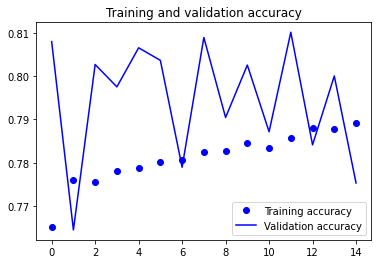

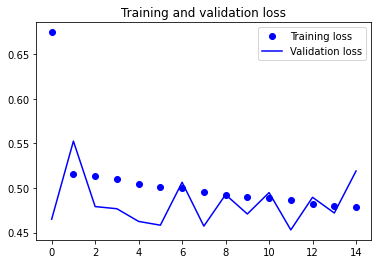

In [30]:
run_training(basic_model, "experiment1_basic", num_epochs=15)

1735/1735 [==============================] - 22s 12ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.8773    0.8630    0.8701     39748
           1     0.6680    0.6955    0.6815     15758

    accuracy                         0.8154     55506
   macro avg     0.7726    0.7792    0.7758     55506
weighted avg     0.8179    0.8154    0.8165     55506

Matrice di confusione:
[[34302  5446]
 [ 4799 10959]]
Classification report:
              precision    recall  f1-score   support

           0     0.8773    0.8630    0.8701     39748
           1     0.6680    0.6955    0.6815     15758

    accuracy                         0.8154     55506
   macro avg     0.7726    0.7792    0.7758     55506
weighted avg     0.8179    0.8154    0.8165     55506



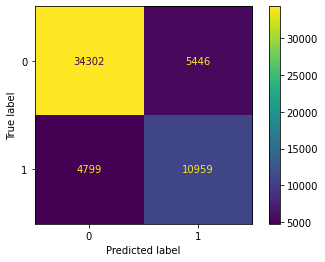

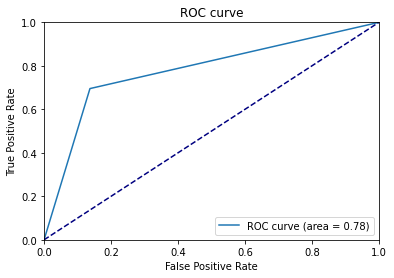

In [31]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/experiment1_basic.h5'),"experiment1_basic")

28/28 [==============================] - 1s 14ms/step


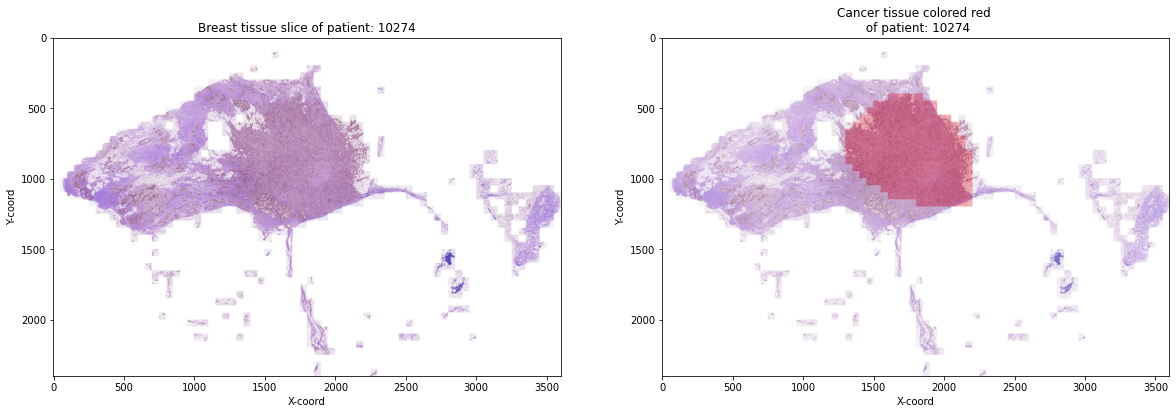

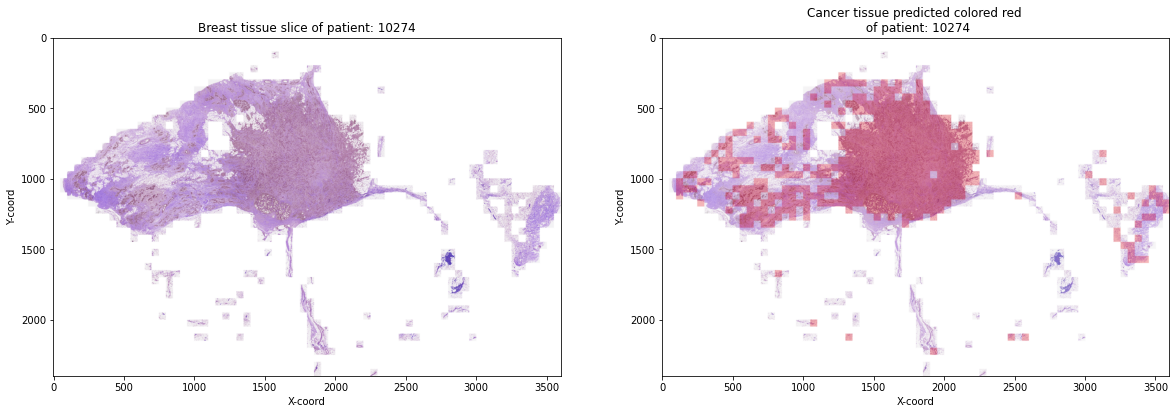

In [32]:
patient_id = "10274"
model = "experiment1_basic.h5"
realty_vs_predict(patient_id,model)

### Experiment 2: Incorporating Dropout


In [33]:
inputs = keras.Input(shape=(50,50,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)
basic_model = keras.Model(inputs, outputs)
compile_model(basic_model)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem_1   (None, 50, 50, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 50, 50, 3)        0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               1313

Epoch 1/15
2952/2955 [============================>.] - ETA: 0s - loss: 2.5842 - accuracy: 0.7346
Epoch 1: val_loss improved from inf to 0.80819, saving model to /content/models/experiment3_dropout.h5
2955/2955 [==============================] - 89s 30ms/step - loss: 2.5830 - accuracy: 0.7346 - val_loss: 0.8082 - val_accuracy: 0.8110
Epoch 2/15
2952/2955 [============================>.] - ETA: 0s - loss: 1.1528 - accuracy: 0.7539
Epoch 2: val_loss improved from 0.80819 to 0.48758, saving model to /content/models/experiment3_dropout.h5
2955/2955 [==============================] - 87s 29ms/step - loss: 1.1523 - accuracy: 0.7539 - val_loss: 0.4876 - val_accuracy: 0.8117
Epoch 3/15
2953/2955 [============================>.] - ETA: 0s - loss: 0.5890 - accuracy: 0.7759
Epoch 3: val_loss improved from 0.48758 to 0.45249, saving model to /content/models/experiment3_dropout.h5
2955/2955 [==============================] - 86s 29ms/step - loss: 0.5890 - accuracy: 0.7758 - val_loss: 0.4525 - val_a

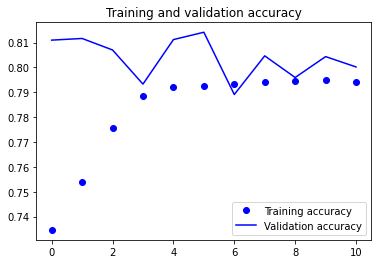

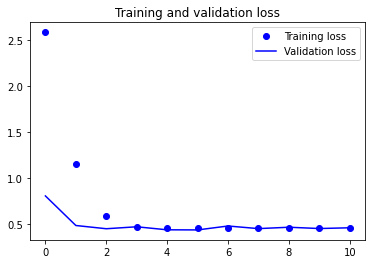

In [34]:
run_training(basic_model, "experiment3_dropout", num_epochs=15)

1735/1735 [==============================] - 21s 12ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.8927    0.8441    0.8677     39748
           1     0.6543    0.7441    0.6963     15758

    accuracy                         0.8157     55506
   macro avg     0.7735    0.7941    0.7820     55506
weighted avg     0.8250    0.8157    0.8191     55506

Matrice di confusione:
[[33552  6196]
 [ 4033 11725]]
Classification report:
              precision    recall  f1-score   support

           0     0.8927    0.8441    0.8677     39748
           1     0.6543    0.7441    0.6963     15758

    accuracy                         0.8157     55506
   macro avg     0.7735    0.7941    0.7820     55506
weighted avg     0.8250    0.8157    0.8191     55506



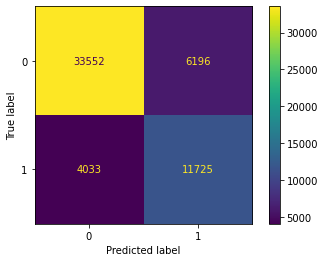

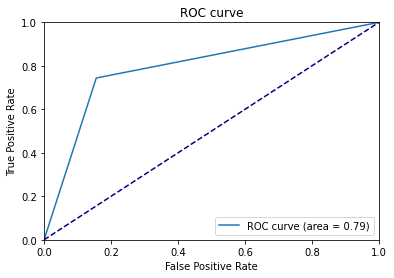

In [35]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/experiment2_dropout.h5'),"experiment2_dropout")

28/28 [==============================] - 1s 15ms/step


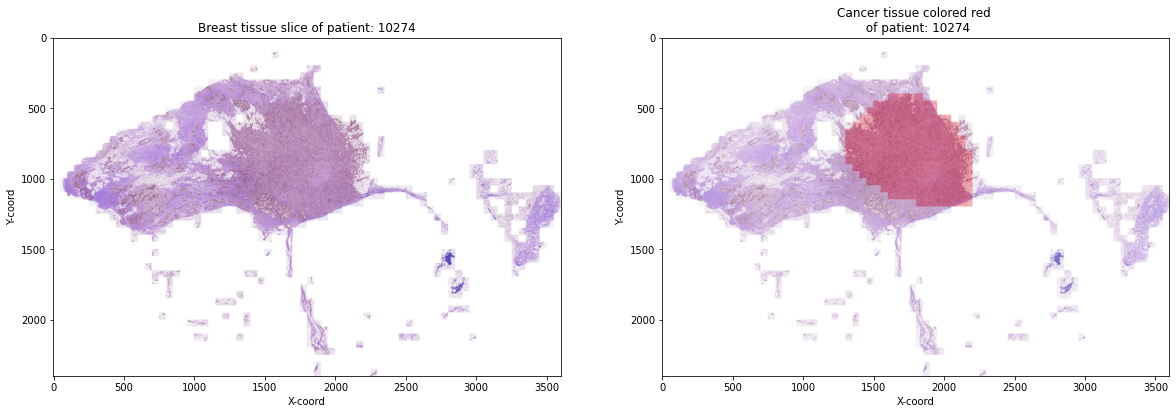

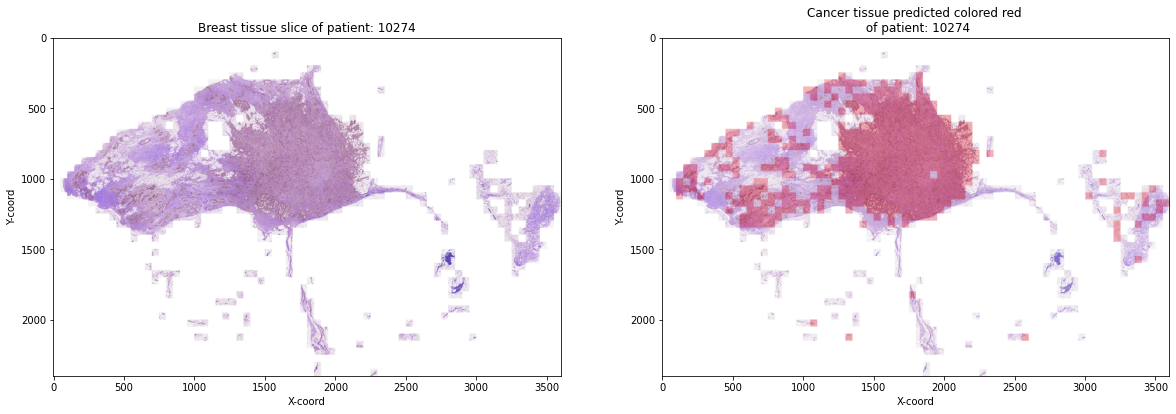

In [36]:
patient_id = "10274"
model = "experiment2_dropout.h5"
realty_vs_predict(patient_id,model)

### Experiment 3: Global average pooling

In [37]:
inputs = keras.Input(shape=(50,50,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)
basic_model = keras.Model(inputs, outputs)
compile_model(basic_model)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem_2   (None, 50, 50, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 50, 50, 3)        0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                           

Epoch 1/15
2954/2955 [============================>.] - ETA: 0s - loss: 2.4880 - accuracy: 0.7361
Epoch 1: val_loss improved from inf to 0.78198, saving model to /content/models/experiment3_dropout_globalAveragePool.h5
2955/2955 [==============================] - 89s 30ms/step - loss: 2.4879 - accuracy: 0.7361 - val_loss: 0.7820 - val_accuracy: 0.8079
Epoch 2/15
2955/2955 [==============================] - ETA: 0s - loss: 1.1124 - accuracy: 0.7570
Epoch 2: val_loss improved from 0.78198 to 0.47886, saving model to /content/models/experiment3_dropout_globalAveragePool.h5
2955/2955 [==============================] - 87s 29ms/step - loss: 1.1124 - accuracy: 0.7570 - val_loss: 0.4789 - val_accuracy: 0.8143
Epoch 3/15
2955/2955 [==============================] - ETA: 0s - loss: 0.5826 - accuracy: 0.7772
Epoch 3: val_loss improved from 0.47886 to 0.45070, saving model to /content/models/experiment3_dropout_globalAveragePool.h5
2955/2955 [==============================] - 86s 29ms/step - loss

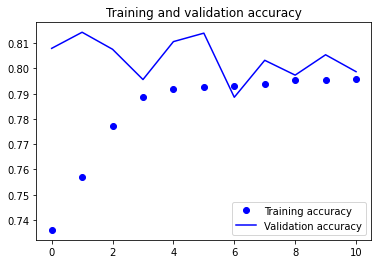

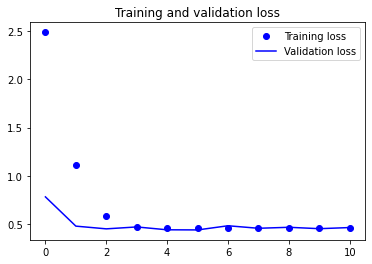

In [38]:
run_training(basic_model, "experiment3_dropout_globalAveragePool", num_epochs=15)

1735/1735 [==============================] - 21s 12ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.8869    0.8598    0.8731     39748
           1     0.6717    0.7234    0.6966     15758

    accuracy                         0.8211     55506
   macro avg     0.7793    0.7916    0.7849     55506
weighted avg     0.8258    0.8211    0.8230     55506

Matrice di confusione:
[[34176  5572]
 [ 4359 11399]]
Classification report:
              precision    recall  f1-score   support

           0     0.8869    0.8598    0.8731     39748
           1     0.6717    0.7234    0.6966     15758

    accuracy                         0.8211     55506
   macro avg     0.7793    0.7916    0.7849     55506
weighted avg     0.8258    0.8211    0.8230     55506



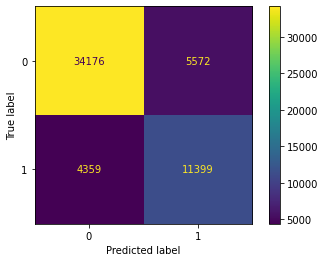

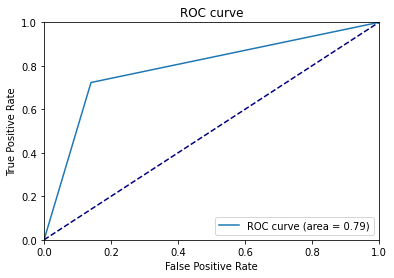

In [39]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/experiment3_dropout_globalAveragePool.h5'),"experiment3_dropout_globalAveragePool")

28/28 [==============================] - 1s 15ms/step


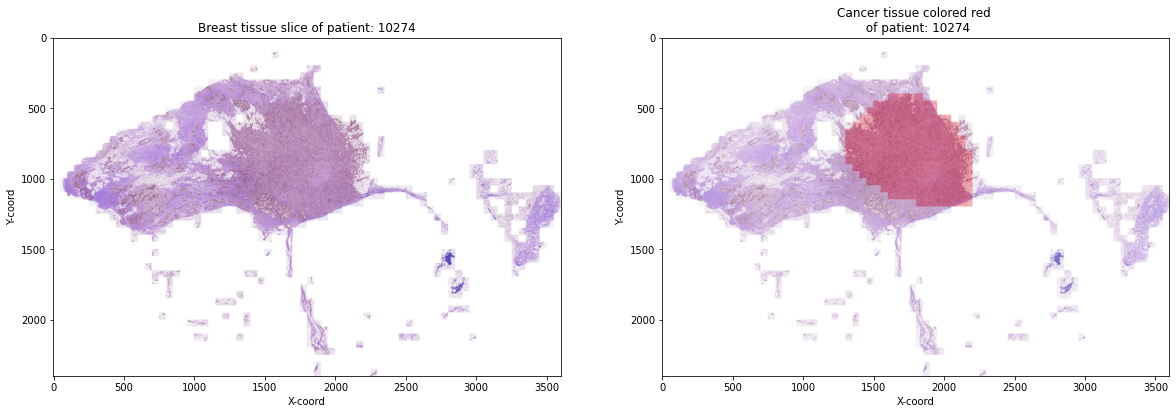

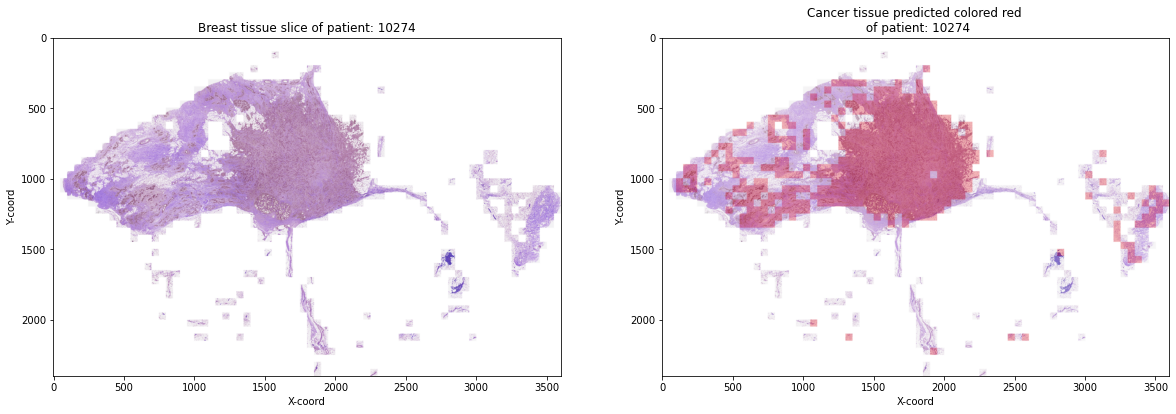

In [40]:
patient_id = "10274"
model = "experiment3_dropout_globalAveragePool.h5"
realty_vs_predict(patient_id,model)

Down below we have the reports of our first 3 experiments in order by experiment, and we note that the second experiment is the one that went slightly better compared to the others.





## Improving Performance with Neural Network Fine-Tuning

###Experiment 4: last block (block5_conv3) with experiment1 


```
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)       295168    
                                                                 
 block3_conv2 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_conv3 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_pool (MaxPooling2D)  (None, 6, 6, 256)         0         
                                                                 
 block4_conv1 (Conv2D)       (None, 6, 6, 512)         1180160   
                                                                 
 block4_conv2 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block4_conv3 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block4_pool (MaxPooling2D)  (None, 3, 3, 512)         0         
                                                                 
 block5_conv1 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 BLOCK5_CONV3 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 1, 1, 512)         0         
                                                                 
=================================================================
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________
```





Take first model with more treaning accuracy "experiment1_basic"

Leave all levels inalienable, except "***block5_conv3***" that will undergo changes to the weights

In [41]:
from tensorflow.keras import layers, models, optimizers

vgg_ft_1_layer = models.load_model(os.path.join(global_model_path, 'experiment1_basic.h5'))

for layer in vgg_ft_1_layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg_ft_1_layer, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_1_layer.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 50, 50, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 50, 50, 3)        0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                             

Epoch 1/15
2954/2955 [============================>.] - ETA: 0s - loss: 0.4231 - accuracy: 0.8126
Epoch 1: val_loss improved from inf to 0.40688, saving model to /content/models/experiment4_fineTuning_block5_conv3 .h5
2955/2955 [==============================] - 96s 32ms/step - loss: 0.4231 - accuracy: 0.8125 - val_loss: 0.4069 - val_accuracy: 0.8264
Epoch 2/15
2954/2955 [============================>.] - ETA: 0s - loss: 0.3800 - accuracy: 0.8342
Epoch 2: val_loss did not improve from 0.40688
2955/2955 [==============================] - 93s 31ms/step - loss: 0.3800 - accuracy: 0.8342 - val_loss: 0.4306 - val_accuracy: 0.8150
Epoch 3/15
2954/2955 [============================>.] - ETA: 0s - loss: 0.3558 - accuracy: 0.8464
Epoch 3: val_loss did not improve from 0.40688
2955/2955 [==============================] - 92s 31ms/step - loss: 0.3559 - accuracy: 0.8463 - val_loss: 0.4203 - val_accuracy: 0.8203
Epoch 4/15
2954/2955 [============================>.] - ETA: 0s - loss: 0.3327 - accura

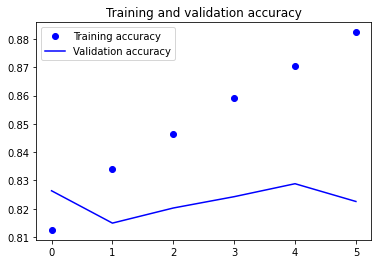

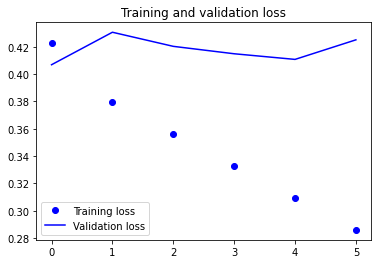

In [42]:
run_training(vgg_ft_1_layer, 'experiment4_fineTuning_block5_conv3 ', num_epochs = 15, patience=5, monitor='val_loss')

1735/1735 [==============================] - 21s 12ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.9047    0.8625    0.8831     39748
           1     0.6897    0.7707    0.7280     15758

    accuracy                         0.8365     55506
   macro avg     0.7972    0.8166    0.8055     55506
weighted avg     0.8436    0.8365    0.8391     55506

Matrice di confusione:
[[34284  5464]
 [ 3613 12145]]
Classification report:
              precision    recall  f1-score   support

           0     0.9047    0.8625    0.8831     39748
           1     0.6897    0.7707    0.7280     15758

    accuracy                         0.8365     55506
   macro avg     0.7972    0.8166    0.8055     55506
weighted avg     0.8436    0.8365    0.8391     55506



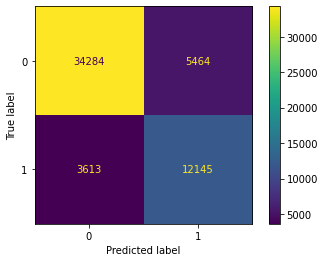

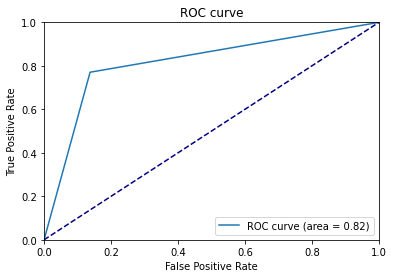

In [43]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/experiment4_fineTuning_block5_conv3 .h5'),"experiment4_fineTuning_block5_conv3")

28/28 [==============================] - 1s 15ms/step


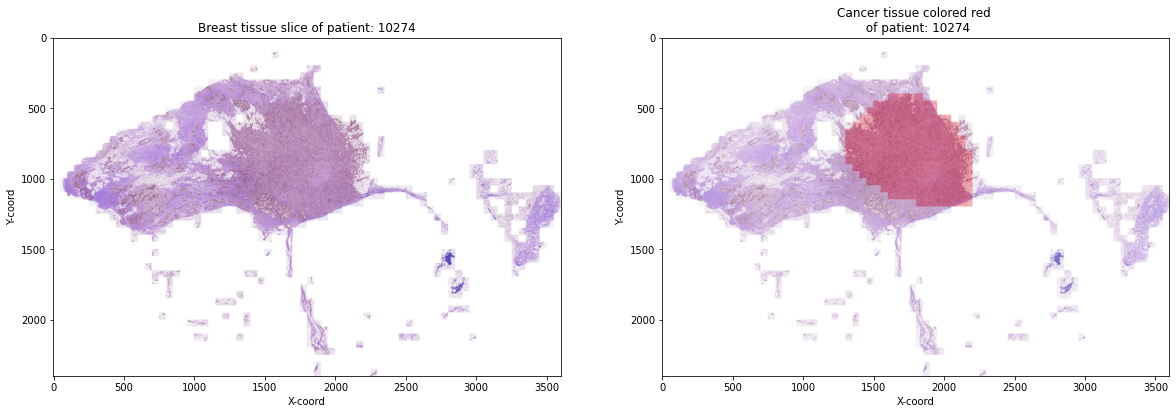

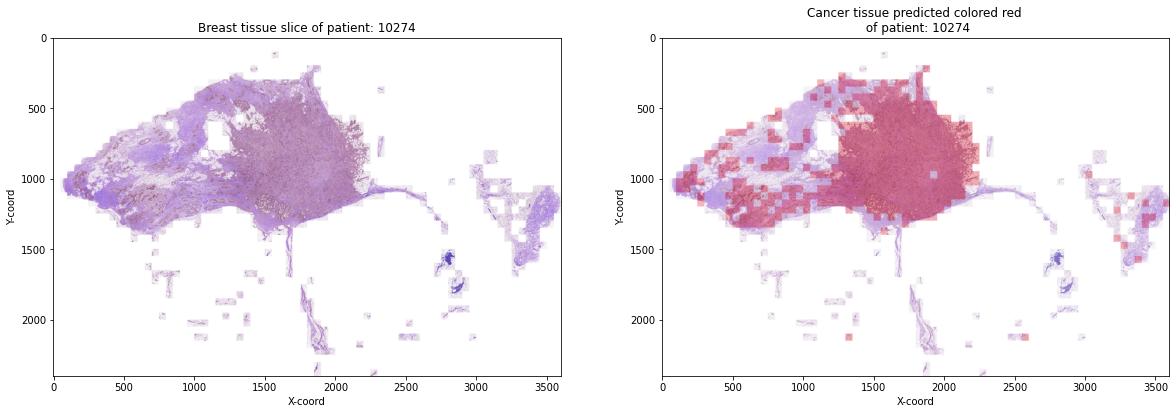

In [44]:
patient_id = "10274"
model = "experiment4_fineTuning_block5_conv3 .h5"
realty_vs_predict(patient_id,model)

###Experiment 4bis last block (block5_conv3) with experiment2

In [17]:
vgg_ft_1_layer = models.load_model(os.path.join(global_model_path, 'experiment2_dropout.h5'))

for layer in vgg_ft_1_layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg_ft_1_layer, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_1_layer.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem_1   (None, 50, 50, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 50, 50, 3)        0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               1313

In [ ]:
run_training(vgg_ft_1_layer, 'experiment4bis_fineTuning_block5_conv3', num_epochs = 15, patience=5, monitor='val_loss')

Epoch 1/15
2955/2955 [==============================] - ETA: 0s - loss: 0.9825 - accuracy: 0.7595
Epoch 1: val_loss improved from inf to 0.48169, saving model to /content/models/experiment4bis_fineTuning_block5_conv3.h5
2955/2955 [==============================] - 106s 32ms/step - loss: 0.9825 - accuracy: 0.7595 - val_loss: 0.4817 - val_accuracy: 0.7968
Epoch 2/15
2952/2955 [============================>.] - ETA: 0s - loss: 0.5135 - accuracy: 0.7912
Epoch 2: val_loss improved from 0.48169 to 0.44550, saving model to /content/models/experiment4bis_fineTuning_block5_conv3.h5
2955/2955 [==============================] - 92s 31ms/step - loss: 0.5134 - accuracy: 0.7913 - val_loss: 0.4455 - val_accuracy: 0.7988
Epoch 3/15
2955/2955 [==============================] - ETA: 0s - loss: 0.4431 - accuracy: 0.8119
Epoch 3: val_loss improved from 0.44550 to 0.43201, saving model to /content/models/experiment4bis_fineTuning_block5_conv3.h5
2955/2955 [==============================] - 91s 31ms/step - 

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/experiment4bis_fineTuning_block5_conv3.h5'),"experiment4bis_fineTuning_block5_conv3")

In [ ]:
patient_id = "10274"
model = "experiment4bis_fineTuning_block5_conv3.h5"
realty_vs_predict(patient_id,model)

### Experiment 5: last block (block5_conv2, block5_conv3, block5_conv1) with experiment1

Leave all levels inalienable, except "***block5_conv1, block5_conv2, block5_conv3***" that will undergo changes to the weights

In [ ]:
vgg_ft_1_layer = models.load_model(os.path.join(global_model_path, 'experiment1_basic.h5'))

for layer in vgg_ft_1_layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3', 'block5_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg_ft_1_layer, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_1_layer.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

In [ ]:
run_training(vgg_ft_1_layer, 'experiment5_fineTuning_block5_conv2__conv3__conv1', num_epochs = 15, patience=5, monitor='val_loss')

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/experiment5_fineTuning_block5_conv2__conv3__conv1.h5'),"experiment5_fineTuning_block5_conv2__conv3__conv1")

In [ ]:
patient_id = "10274"
model = "experiment5_fineTuning_block5_conv2__conv3__conv1.h5"
realty_vs_predict(patient_id,model)

### Experiment 5bis: last block (block5_conv2, block5_conv3, block5_conv1) with experiment2

In [ ]:
vgg_ft_1_layer = models.load_model(os.path.join(global_model_path, 'experiment2_dropout.h5'))

for layer in vgg_ft_1_layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3', 'block5_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg_ft_1_layer, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_1_layer.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

In [ ]:
run_training(vgg_ft_1_layer, 'experiment5bis_fineTuning_block5_conv2__conv3__conv1', num_epochs = 15, patience=5, monitor='val_loss')

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/experiment5bis_fineTuning_block5_conv2__conv3__conv1.h5'),"experiment5bis_fineTuning_block5_conv2__conv3__conv1")

In [ ]:
patient_id = "10274"
model = "experiment5bis_fineTuning_block5_conv2__conv3__conv1.h5"
realty_vs_predict(patient_id,model)

###Experiment 6: two block with experiment2

In [ ]:
vgg16_ft_2_blocks = models.load_model(os.path.join(global_model_path, 'experiment2_dropout.h5'))

for layer in vgg16_ft_2_blocks.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3', 'block5_conv1', 'block4_conv3', 'block4_conv2', 'block4_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg16_ft_2_blocks, learning_rate=1e-5)

for i, layer in enumerate(vgg16_ft_2_blocks.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

In [ ]:
run_training(vgg16_ft_2_blocks, 'experiment6_fineTuning_block5__block4', num_epochs = 15, patience=5, monitor='val_loss')

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/experiment6_fineTuning_block5__block4.h5'),"experiment6_fineTuning_block5__block4")

In [ ]:
patient_id = "10274"
model = "experiment6_fineTuning_block5__block4.h5"
realty_vs_predict(patient_id,model)

#Eliminate Block

###Experiment 7: Eliminate "***block5_conv1, block5_conv2,  block5_conv3***" Layers

In [ ]:
model = Sequential()
for layer in conv_base.layers:
  if layer.name in ('block5_conv2', 'block5_conv3', 'block5_conv1'):
    break
  layer.trainable = False
  model.add(layer)

model.summary()
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

In [ ]:
inputs = keras.Input(shape=(50,50,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = model(x)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)
vgg_cut_model = keras.Model(inputs, outputs)
compile_model(vgg_cut_model)

In [ ]:
run_training(vgg_cut_model, 'experiment7_cut_block5 ', num_epochs = 15, patience=5, monitor='val_loss')

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/experiment7_cut_block5 .h5'),"experiment7_cut_block5") 

In [ ]:
patient_id = "10274"
model = "experiment7_cut_block5 .h5"
realty_vs_predict(patient_id,model)

# Fine Tuning in model with removal

#Experiment 8: block4

In [ ]:
vgg16_remove_blocks = models.load_model(os.path.join(global_model_path, 'experiment7_cut_block5 .h5'))

for layer in vgg16_remove_blocks.get_layer('sequential').layers:
    if layer.name in ('block5_conv2', 'block5_conv3', 'block5_conv1', 'block4_conv3', 'block4_conv2', 'block4_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg16_remove_blocks, learning_rate=1e-5)

for i, layer in enumerate(vgg16_remove_blocks.get_layer('sequential').layers):
    print(i, layer.name, layer.trainable)

In [ ]:
run_training(vgg16_remove_blocks, 'experiment8_FT_block4', num_epochs = 1, patience=5, monitor='val_loss')

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/experiment8_FT_block4.h5'))

In [ ]:
patient_id = "10274"
model = "experiment8_FT_block4.h5"
realty_vs_predict(patient_id,model)

In [ ]:
!pip install opencv-python

# CLAHE

In [ ]:
# Create two empty arrays to store the processed images and their labels
non_img_arr = []
can_img_arr = []

# Crea un'istanza di CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# Loop through the list of file names in N_IDC
for img in N_IDC:
    
    # Read the image using OpenCV's imread function
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    
    # Split the image into its individual color channels
    b, g, r = cv2.split(n_img)
    
    # Apply CLAHE to each color channel
    b = clahe.apply(b)
    g = clahe.apply(g)
    r = clahe.apply(r)
    
    # Merge the CLAHE-processed color channels back into an RGB image
    n_img = cv2.merge((b, g, r))

    # Resize the image to 50x50 using OpenCV's resize function
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    
    # Add the resized image and label (0) to the non_img_arr list
    non_img_arr.append([n_img_size, 0])
    
# Loop through the list of file names in P_IDC
for img in P_IDC:
    # Read the image using OpenCV's imread function
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    
    # Split the image into its individual color channels
    b, g, r = cv2.split(c_img)
    
    # Apply CLAHE to each color channel
    b = clahe.apply(b)
    g = clahe.apply(g)
    r = clahe.apply(r)
    
    # Merge the CLAHE-processed color channels back into an RGB image
    c_img = cv2.merge((b, g, r))

    # Resize the image to 50x50 using OpenCV's resize function
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    
    # Add the resized image and label (1) to the can_img_arr list
    can_img_arr.append([c_img_size, 1])

In [ ]:
print(f"negative: {len(non_img_arr)} with perc: {(1-len(can_img_arr)/len(non_img_arr))*100}%, positive: {len(can_img_arr)} with perc: {(len(can_img_arr)/len(non_img_arr))*100}%")
length = int(len(non_img_arr))
train_non_img_arr = non_img_arr[:int(0.6 * length)]
validation_non_img_arr = non_img_arr[int(0.6 * length): int(0.8 * length)]
test_non_img_arr = non_img_arr[int(0.8 * length):int(length)]
print(f"len of train_negative: {len(train_non_img_arr)}, len of validation_negative: {len(validation_non_img_arr)}, len of test_negative: {len(test_non_img_arr)} ")

length = int(len(can_img_arr))
train_can_img_arr = can_img_arr[:int(0.6 * length)]
validation_can_img_arr = can_img_arr[int(0.6 * length): int(0.8 * length)]
test_can_img_arr = can_img_arr[int(0.8 * length):int(length)]
print(f"len of train_positive: {len(train_can_img_arr)}, len of validation_positive: {len(validation_can_img_arr)}, len of test_positive: {len(test_can_img_arr)} ")

length = len(train_can_img_arr)
random.shuffle(train_non_img_arr)
train_non_img_arr = train_non_img_arr[:int(length)]
print(f"new len of train_negative {len(train_non_img_arr)}. Now, the len of postive and negative sample is same")


train = np.concatenate((train_non_img_arr,train_can_img_arr))
validation = np.concatenate((validation_non_img_arr,validation_can_img_arr))
test = np.concatenate((test_non_img_arr,test_can_img_arr))

train_idx = np.random.permutation(train.shape[0])
train = train[train_idx]

validation_idx = np.random.permutation(validation.shape[0])
validation = validation[validation_idx]

test_idx = np.random.permutation(test.shape[0])
test = test[test_idx]

negative: 198738 with perc: 60.35685173444434%, positive: 78786 with perc: 39.64314826555565%
len of train_negative: 119242, len of validation_negative: 39748, len of test_negative: 39748 
len of train_positive: 47271, len of validation_positive: 15757, len of test_positive: 15758 
new len of train_negative 47271. Now, the len of postive and negative sample is same


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
X_train = []
X_test = []
X_val = []
Y_train = []
Y_test = [] 
Y_val = []


for feature, label in train:
    X_train.append(feature)
    Y_train.append(label)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

for feature, label in validation:
    X_val.append(feature)
    Y_val.append(label)
X_val = np.array(X_val)
Y_val = np.array(Y_val)

for feature, label in test:
    X_test.append(feature)
    Y_test.append(label)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [ ]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
Y_val = to_categorical(Y_val, num_classes = 2)


print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (94542, 50, 50, 3)
Validation Data Shape: (55505, 50, 50, 3)
Testing Data Shape: (55506, 50, 50, 3)


In [ ]:
from tensorflow.keras import layers
import tensorflow as tf

model = Sequential()
for layer in conv_base.layers:
  if layer.name in ('block5_conv2', 'block5_conv3', 'block5_conv1'):
    break
  layer.trainable = False
  model.add(layer)

model.summary()
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)      

In [ ]:
inputs = keras.Input(shape=(50,50,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = model(x)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)
vgg_cut_model = keras.Model(inputs, outputs)
compile_model(vgg_cut_model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 50, 50, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 50, 50, 3)        0         
                                                                 
 sequential_1 (Sequential)   (None, 3, 3, 512)         7635264   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328

2702/2702 [==============================] - 61s 22ms/step - loss: 20.4579 - accuracy: 0.7655 - val_loss: 6.4956 - val_accuracy: 0.8242


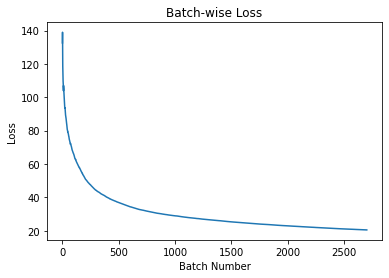

In [ ]:
run_training(vgg_cut_model, 'firstPhase_CLAHE ', num_epochs = 1, patience=5, monitor='val_loss')

1735/1735 [==============================] - 17s 10ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.9100    0.8578    0.8831     39748
           1     0.6866    0.7861    0.7330     15758

    accuracy                         0.8374     55506
   macro avg     0.7983    0.8219    0.8081     55506
weighted avg     0.8466    0.8374    0.8405     55506

Matrice di confusione:
[[34094  5654]
 [ 3370 12388]]
Classification report:
              precision    recall  f1-score   support

           0     0.9100    0.8578    0.8831     39748
           1     0.6866    0.7861    0.7330     15758

    accuracy                         0.8374     55506
   macro avg     0.7983    0.8219    0.8081     55506
weighted avg     0.8466    0.8374    0.8405     55506



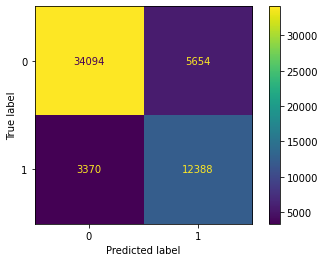

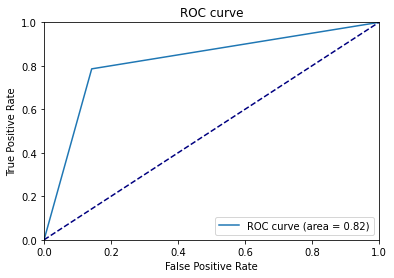

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/firstPhase_CLAHE .h5'))

In [ ]:
#second model phase
vgg16_remove_blocks = models.load_model(os.path.join(global_model_path, 'firstPhase_CLAHE .h5'))

for layer in vgg16_remove_blocks.get_layer('sequential_1').layers:
    if layer.name in ('block4_conv3', 'block4_conv2', 'block4_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg16_remove_blocks, learning_rate=1e-5)

for i, layer in enumerate(vgg16_remove_blocks.get_layer('sequential_1').layers):
    print(i, layer.name, layer.trainable)




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 50, 50, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 50, 50, 3)        0         
                                                                 
 sequential_1 (Sequential)   (None, 3, 3, 512)         7635264   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328

2702/2702 [==============================] - 87s 31ms/step - loss: 1.7022 - accuracy: 0.7859 - val_loss: 0.4309 - val_accuracy: 0.8117


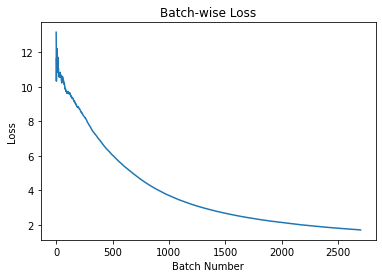

In [ ]:
run_training(vgg16_remove_blocks, 'secondPhase_CLAHE', num_epochs = 1, patience=5, monitor='val_loss')

1735/1735 [==============================] - 16s 9ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.9017    0.8495    0.8748     39748
           1     0.6688    0.7665    0.7143     15758

    accuracy                         0.8259     55506
   macro avg     0.7853    0.8080    0.7946     55506
weighted avg     0.8356    0.8259    0.8293     55506

Matrice di confusione:
[[33767  5981]
 [ 3680 12078]]
Classification report:
              precision    recall  f1-score   support

           0     0.9017    0.8495    0.8748     39748
           1     0.6688    0.7665    0.7143     15758

    accuracy                         0.8259     55506
   macro avg     0.7853    0.8080    0.7946     55506
weighted avg     0.8356    0.8259    0.8293     55506



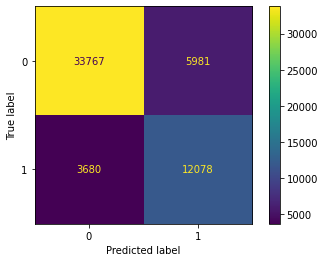

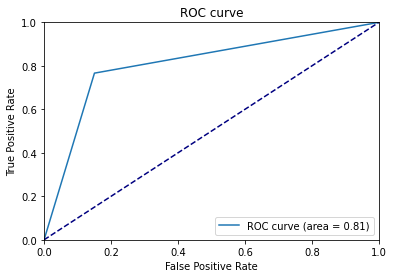

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/secondPhase_CLAHE.h5'))

In [ ]:
#third model phase
vgg16_remove_blocks = models.load_model(os.path.join(global_model_path, 'secondPhase_CLAHE.h5'))

for layer in vgg16_remove_blocks.get_layer('sequential_1').layers:
    if layer.name in ('block3_conv3', 'block3_conv2', 'block3_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg16_remove_blocks, learning_rate=1e-5)

for i, layer in enumerate(vgg16_remove_blocks.get_layer('sequential_1').layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 50, 50, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 50, 50, 3)        0         
                                                                 
 sequential_1 (Sequential)   (None, 3, 3, 512)         7635264   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328

2702/2702 [==============================] - 89s 31ms/step - loss: 0.4197 - accuracy: 0.8243 - val_loss: 0.4774 - val_accuracy: 0.7921


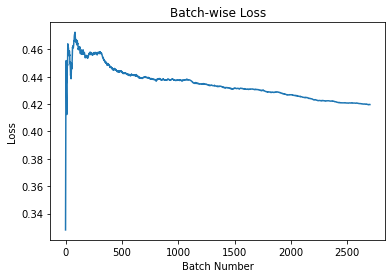

In [ ]:
run_training(vgg16_remove_blocks, 'thirdPhase_CLAHE', num_epochs = 1, patience=5, monitor='val_loss')

1735/1735 [==============================] - 16s 9ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.9405    0.7715    0.8476     39748
           1     0.6033    0.8768    0.7148     15758

    accuracy                         0.8014     55506
   macro avg     0.7719    0.8241    0.7812     55506
weighted avg     0.8448    0.8014    0.8099     55506

Matrice di confusione:
[[30664  9084]
 [ 1941 13817]]
Classification report:
              precision    recall  f1-score   support

           0     0.9405    0.7715    0.8476     39748
           1     0.6033    0.8768    0.7148     15758

    accuracy                         0.8014     55506
   macro avg     0.7719    0.8241    0.7812     55506
weighted avg     0.8448    0.8014    0.8099     55506



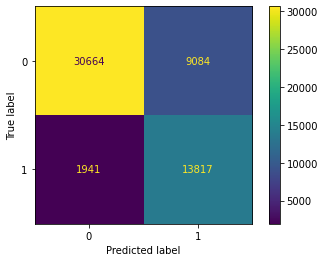

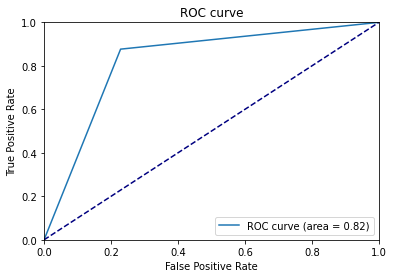

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/thirdPhase_CLAHE.h5'))

In [ ]:
#fourth model phase
vgg16_remove_blocks = models.load_model(os.path.join(global_model_path, 'thirdPhase_CLAHE.h5'))

for layer in vgg16_remove_blocks.get_layer('sequential_1').layers:
    if layer.name in ('block2_conv3', 'block2_conv2', 'block2_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg16_remove_blocks, learning_rate=1e-5)

for i, layer in enumerate(vgg16_remove_blocks.get_layer('sequential_1').layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 50, 50, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 50, 50, 3)        0         
                                                                 
 sequential_1 (Sequential)   (None, 3, 3, 512)         7635264   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328

2702/2702 [==============================] - 92s 34ms/step - loss: 0.3849 - accuracy: 0.8357 - val_loss: 0.3708 - val_accuracy: 0.8399


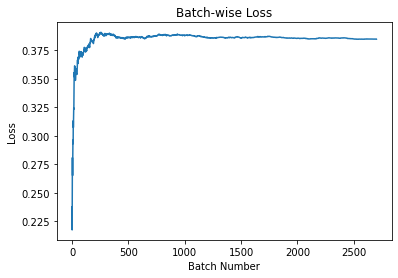

In [ ]:
run_training(vgg16_remove_blocks, 'fourthPhase_CLAHE', num_epochs = 1, patience=5, monitor='val_loss')

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/fourthPhase_CLAHE.h5'))

In [ ]:
#fifth model phase
vgg16_remove_blocks = models.load_model(os.path.join(global_model_path, 'fourthPhase_CLAHE.h5'))

for layer in vgg16_remove_blocks.get_layer('sequential_1').layers:
    if layer.name in ('block1_conv3', 'block1_conv2', 'block1_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg16_remove_blocks, learning_rate=1e-5)

for i, layer in enumerate(vgg16_remove_blocks.get_layer('sequentisequential_1al_18').layers):
    print(i, layer.name, layer.trainable)

In [ ]:
run_training(vgg16_remove_blocks, 'fifthPhase_CLAHE', num_epochs = 1, patience=5, monitor='val_loss')

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/fifthPhase_CLAHE.h5'))

In [ ]:
#sixth model phase
vgg16_remove_blocks = models.load_model(os.path.join(global_model_path, 'fifthPhase_CLAHE.h5'))

for layer in vgg16_remove_blocks.get_layer('sequential_1').layers:
        layer.trainable = True
   

compile_model(vgg16_remove_blocks, learning_rate=1e-5)

for i, layer in enumerate(vgg16_remove_blocks.get_layer('sequential_1').layers):
    print(i, layer.name, layer.trainable)

In [ ]:
run_training(vgg16_remove_blocks, 'sixthPhase_CLAHE', num_epochs = 1, patience=5, monitor='val_loss')

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/sixthPhase_CLAHE.h5'))

In [ ]:
patient_id = "10274"
model = "sixthPhase_CLAHE.h5"
realty_vs_predict(patient_id,model)